In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [24]:
home_values_dataset = pd.read_csv('homevalue.csv')
income = pd.read_csv('median_income.csv')
home_values_dataset.columns.values[5:] = pd.to_datetime(home_values_dataset.columns[5:])
home_values_dataset.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00
0,102001,0,United States,country,NaN,119729.572640,119940.215341,120201.443305,120761.726012,121406.544234,...,350165.829700,351570.606154,352120.860853,352265.907749,352504.359843,352945.853239,353522.496915,354005.575460,354711.020713,355327.955070
1,394913,1,"New York, NY",msa,NY,214911.652349,215824.905614,216746.617250,218614.361683,220548.475724,...,647851.001125,652477.077381,655536.133683,658263.386724,661979.750511,665977.942675,669477.234967,672228.240789,673999.838327,675063.976036
2,753899,2,"Los Angeles, CA",msa,CA,218489.647448,219302.706154,220385.692595,222540.471813,224897.124751,...,911031.498845,916863.716873,920777.178084,925109.643477,930243.585193,936603.517696,941773.674116,946228.303841,950210.062120,950740.494586
3,394463,3,"Chicago, IL",msa,IL,150432.480390,150571.737044,150836.953795,151496.747161,152290.399220,...,311972.006665,314053.134292,315253.946820,315976.493240,316881.631507,317866.656523,318826.563429,319846.118364,321070.725716,322389.516129
4,394514,4,"Dallas, TX",msa,TX,125268.936932,125324.732154,125388.874474,125555.445340,125775.064467,...,372240.198836,372383.086130,371723.001722,370790.474579,370143.446717,369946.958796,369841.800601,369555.460608,369035.088390,368515.900537


In [25]:
#Cleaning Data

print("\nBefore dropping missing values:")
print("New shape for home_values:", home_values_dataset.shape)

threshold = 0.4
home_values = home_values_dataset.loc[home_values_dataset.isnull().mean(axis=1) < threshold]

#home_values_reduced.dropna(inplace=True)

print("\nAfter dropping missing values:")
print("New shape for home_values:", home_values.shape)


Before dropping missing values:
New shape for home_values: (895, 306)

After dropping missing values:
New shape for home_values: (771, 306)


In [26]:
# Interpolate across columns (i.e., across time for each region)
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].interpolate(axis=1)

# Optionally fill any remaining edge NaNs with forward/backward fill
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].bfill(axis=1).ffill(axis=1)

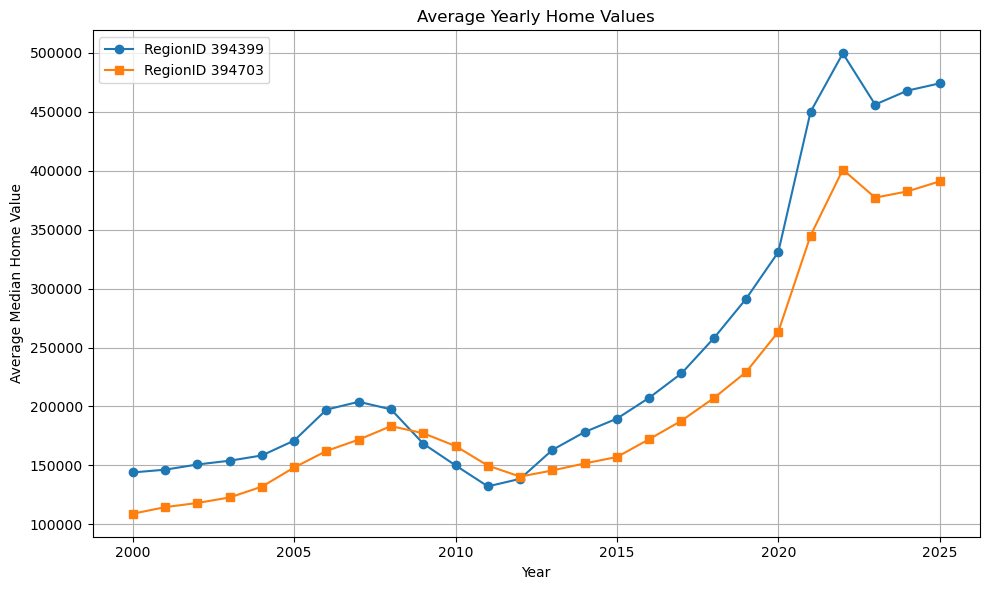

In [27]:
# Step 1: Extract the time series part
ts_1 = home_values[home_values['RegionID'] == 394399].iloc[:, 5:].squeeze()
ts_2 = home_values[home_values['RegionID'] == 394703].iloc[:, 5:].squeeze()

ts_1.index = pd.to_datetime(ts_1.index)
ts_2.index = pd.to_datetime(ts_2.index)

# Step 2: Group by year and calculate the average
ts_1_yearly = ts_1.groupby(ts_1.index.year).mean()
ts_2_yearly = ts_2.groupby(ts_2.index.year).mean()

# Step 3: Plot

plt.figure(figsize=(10, 6))
plt.plot(ts_1_yearly.index, ts_1_yearly.values, marker='o', linestyle='-', label='RegionID 394399')
plt.plot(ts_2_yearly.index, ts_2_yearly.values, marker='s', linestyle='-', label='RegionID 394703')

plt.title('Average Yearly Home Values')
plt.xlabel('Year')
plt.ylabel('Average Median Home Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

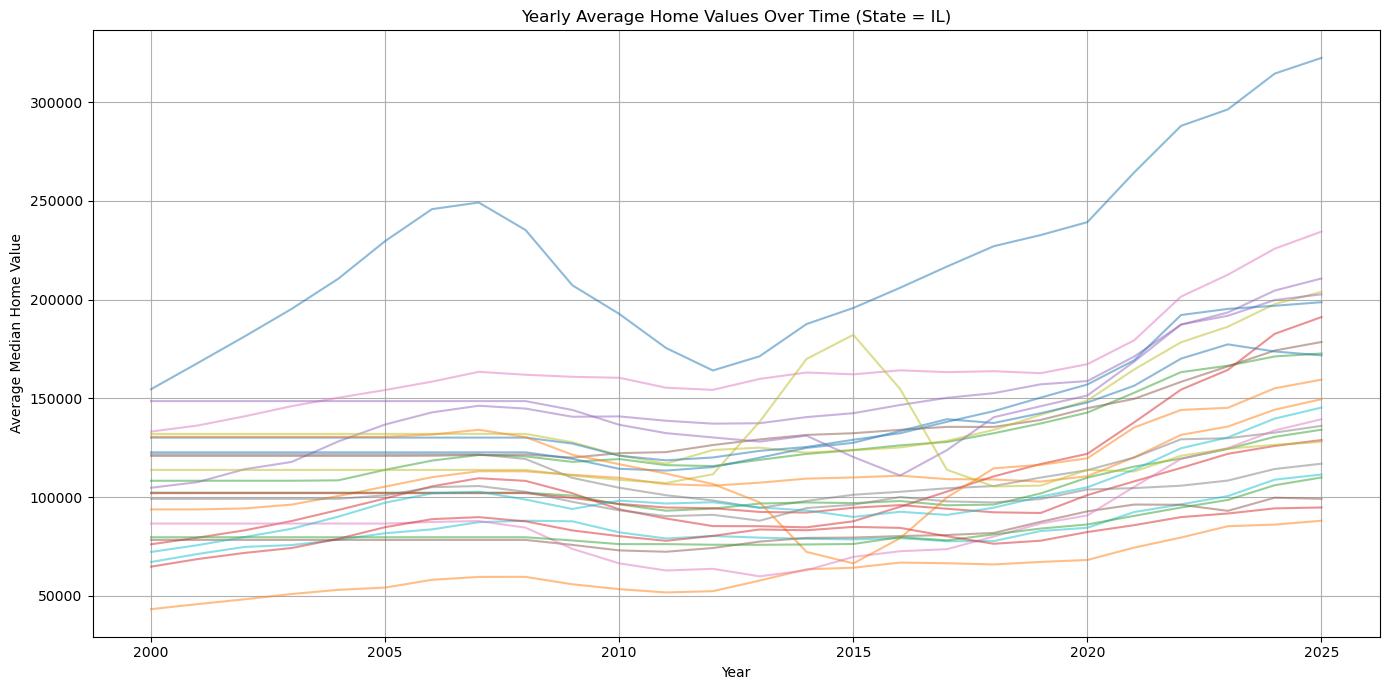

In [28]:
# Step 1: Filter only Illinois rows
illinois_data = home_values[home_values['StateName'] == 'IL']

# Step 2: Extract and transpose the time series portion
ts_data = illinois_data.iloc[:, 5:].T
ts_data.index = pd.to_datetime(ts_data.index)  # ensure datetime index
ts_data.columns = illinois_data['RegionID'].values  # set columns as RegionIDs

# Step 3: Group by year and calculate yearly average for each region
ts_yearly = ts_data.groupby(ts_data.index.year).mean()

# Step 4: Plot
plt.figure(figsize=(14, 7))
for region_id in ts_yearly.columns:
    plt.plot(ts_yearly.index, ts_yearly[region_id], alpha=0.5)

plt.title('Yearly Average Home Values Over Time (State = IL)')
plt.xlabel('Year')
plt.ylabel('Average Median Home Value')
plt.grid(True)
plt.tight_layout()
plt.show()

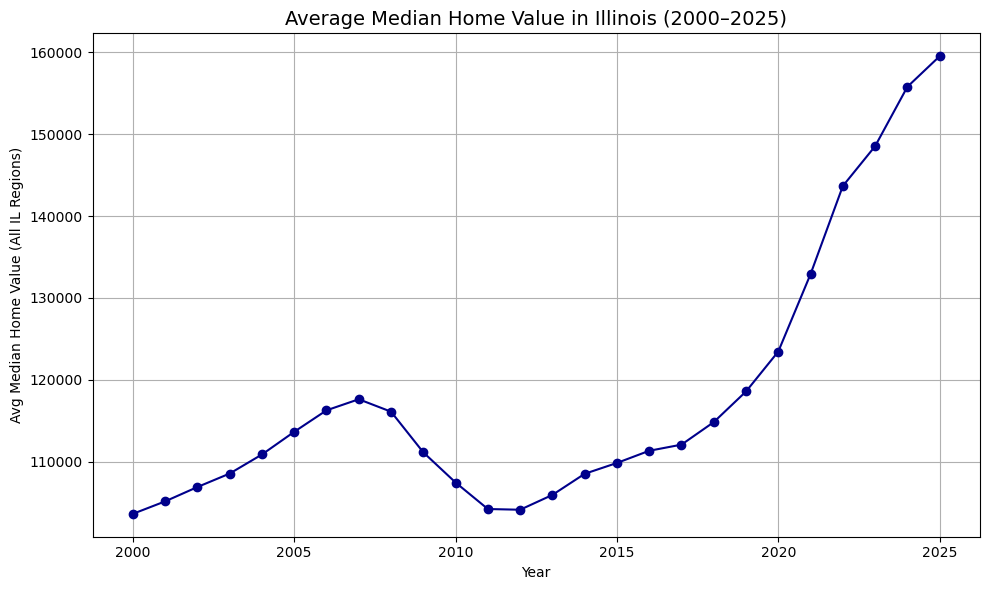

In [29]:
illinois_data = home_values[home_values['StateName'] == 'IL']

# Step 2: Extract and transpose time series
ts_data = illinois_data.iloc[:, 5:].T
ts_data.index = pd.to_datetime(ts_data.index)
ts_data.columns = illinois_data['RegionID'].values

# Step 3: Group by year and average across regions
ts_yearly = ts_data.groupby(ts_data.index.year).mean()

# Step 4: Calculate the average home value across all IL regions (per year)
il_yearly_avg = ts_yearly.mean(axis=1)

# Step 5: Plot it
plt.figure(figsize=(10, 6))
plt.plot(il_yearly_avg.index, il_yearly_avg.values, marker='o', linestyle='-', color='darkblue')
plt.title('Average Median Home Value in Illinois (2000–2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Avg Median Home Value (All IL Regions)')
plt.grid(True)
plt.tight_layout()
plt.show()

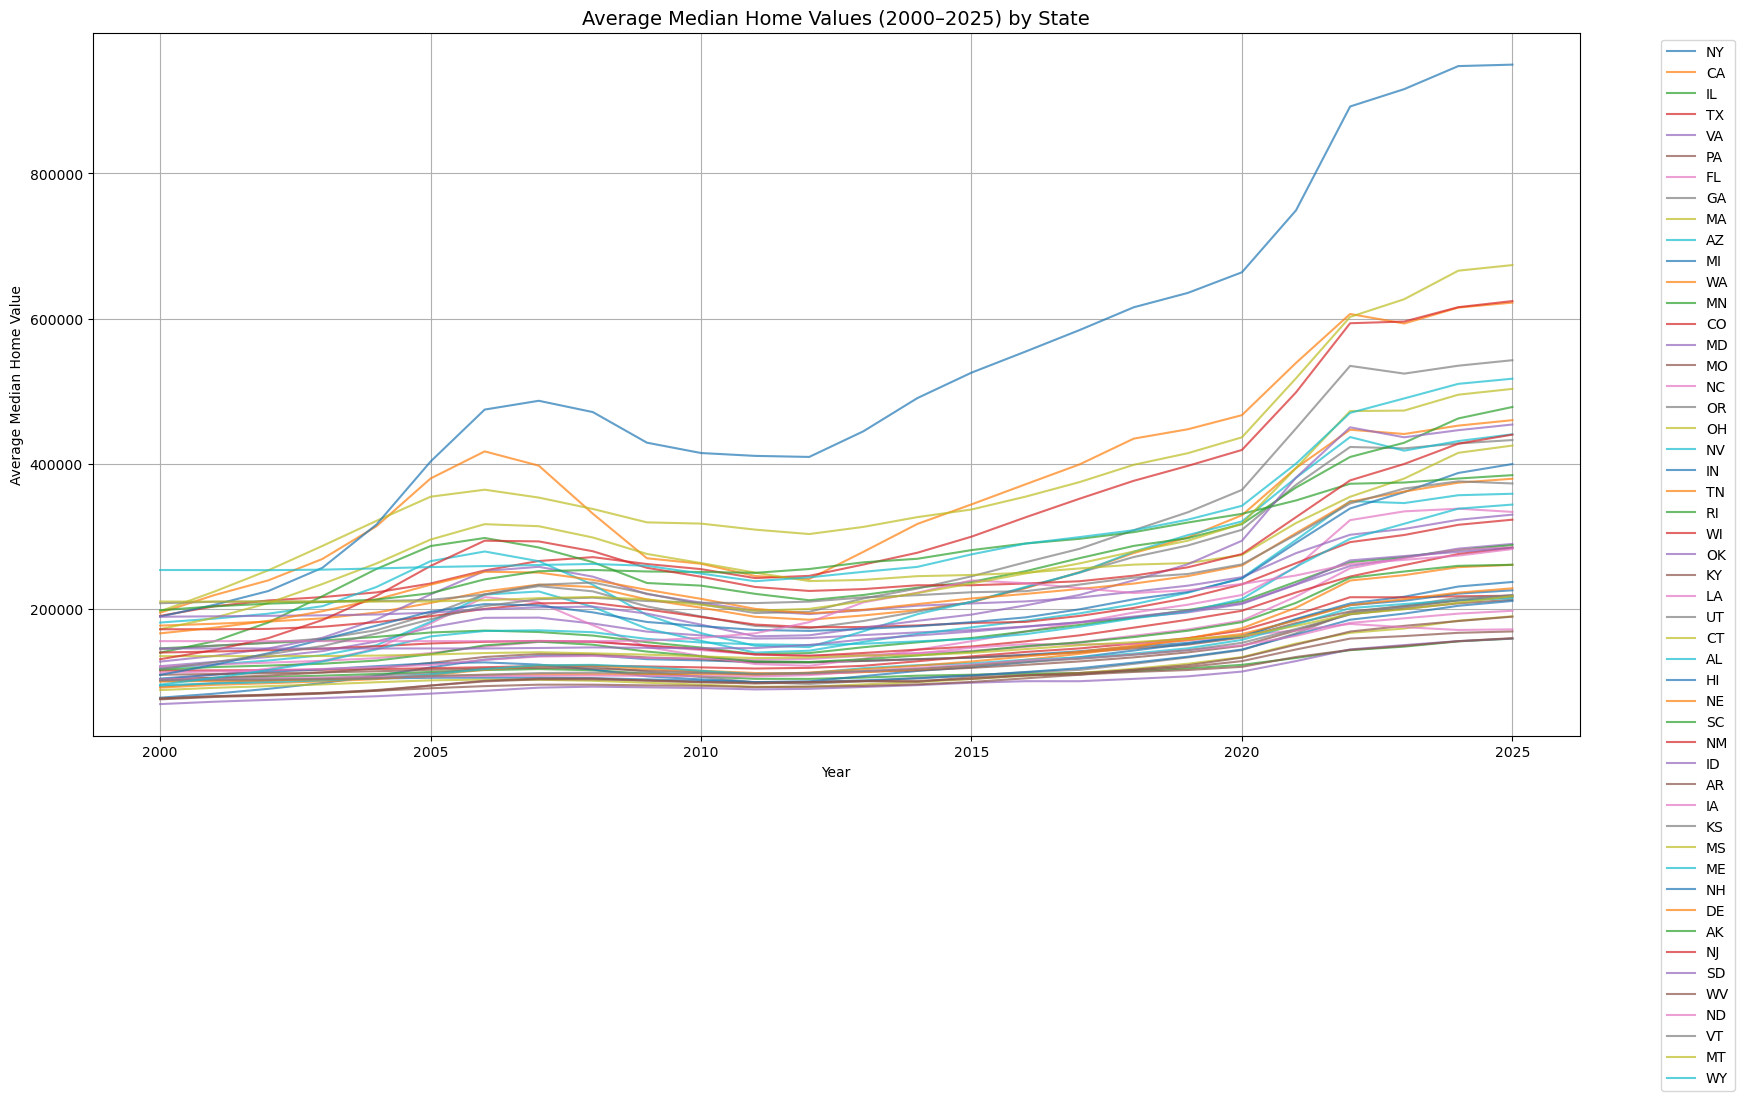

In [30]:
# Create an empty list to store each state's yearly average series
state_rows = []

# Loop over each unique state
for state in home_values['StateName'].unique():
    # Step 1: Filter data for the state
    state_data = home_values[home_values['StateName'] == state]
    
    # Step 2: Extract and transpose time series
    ts_data = state_data.iloc[:, 5:].T
    ts_data.index = pd.to_datetime(ts_data.index)
    ts_data.columns = state_data['RegionID'].values
    
    # Step 3: Group by year and average across regions
    ts_yearly = ts_data.groupby(ts_data.index.year).mean()
    
    # Step 4: Average across all regions in the state per year
    state_avg_series = ts_yearly.mean(axis=1)
    
    # Step 5: Add the state name and store as a dictionary
    state_row = {'StateName': state}
    state_row.update(state_avg_series.to_dict())
    state_rows.append(state_row)

# Create final DataFrame
state_yearly_df = pd.DataFrame(state_rows)

# Optional: Set StateName as index and sort columns by year
state_yearly_df = state_yearly_df.set_index('StateName')
state_yearly_df = state_yearly_df[sorted(state_yearly_df.columns)]
state_yearly_df = state_yearly_df.drop(index=np.nan)

df_plot = state_yearly_df.T  # shape: (years, states)

# Plot
plt.figure(figsize=(16, 8))

for state in df_plot.columns:
    plt.plot(df_plot.index, df_plot[state], label=state, alpha=0.7)

plt.title('Average Median Home Values (2000–2025) by State', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Median Home Value')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)  # puts legend outside the plot
plt.show()

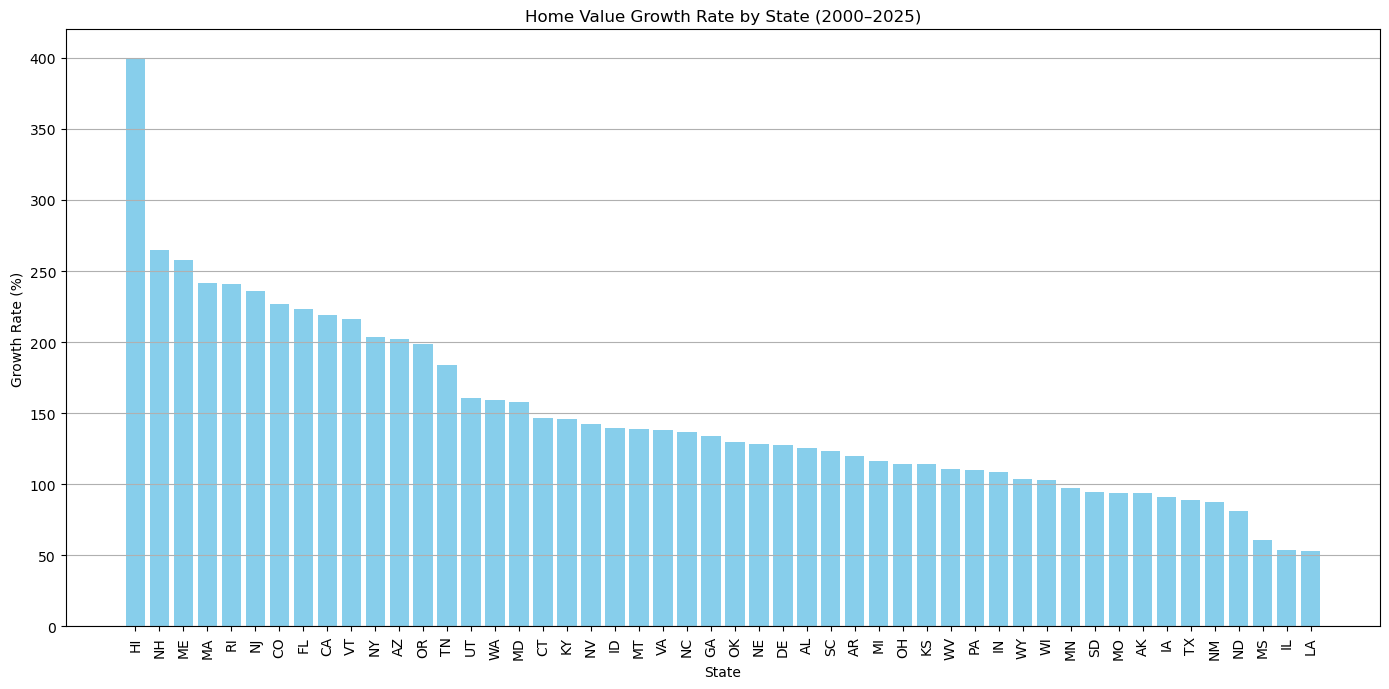

In [31]:
# Make sure years are in the correct format (int)
start_year = 2000
end_year = 2025

# Calculate % change from 2000 to 2025 for each state
growth_rate = ((state_yearly_df[end_year] - state_yearly_df[start_year]) / state_yearly_df[start_year]) * 100

# Create a new DataFrame for visualization
growth_df = pd.DataFrame({
    'StateName': growth_rate.index,
    'GrowthRate (%)': growth_rate.values
})

# Sort from highest to lowest
growth_df = growth_df.sort_values(by='GrowthRate (%)', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 7))
plt.bar(growth_df['StateName'], growth_df['GrowthRate (%)'], color='skyblue')
plt.title('Home Value Growth Rate by State (2000–2025)')
plt.xlabel('State')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [35]:
# Step 1: Remove commas and convert to numeric
income = pd.read_csv('median_income.csv')
for col in income.columns[1:]:  # skip 'State' column
    income[col] = income[col].replace(',', '', regex=True).astype(float)

# Step 2: Add state codes (e.g. IL, CA, NY)
# We'll use a mapping from state name to abbreviation
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD','Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV','New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND','Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD','Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV','Wisconsin': 'WI', 'Wyoming': 'WY', 'The United States': 'US'}

# Add a new column with state abbreviations
income['StateCode'] = income['State'].map(us_state_abbrev)

# Step 3: Optional — ensure year columns are int type (they might be strings)
income.columns = [int(col) if col.isdigit() else col for col in income.columns]
income = income[income['State'] != 'The United States']

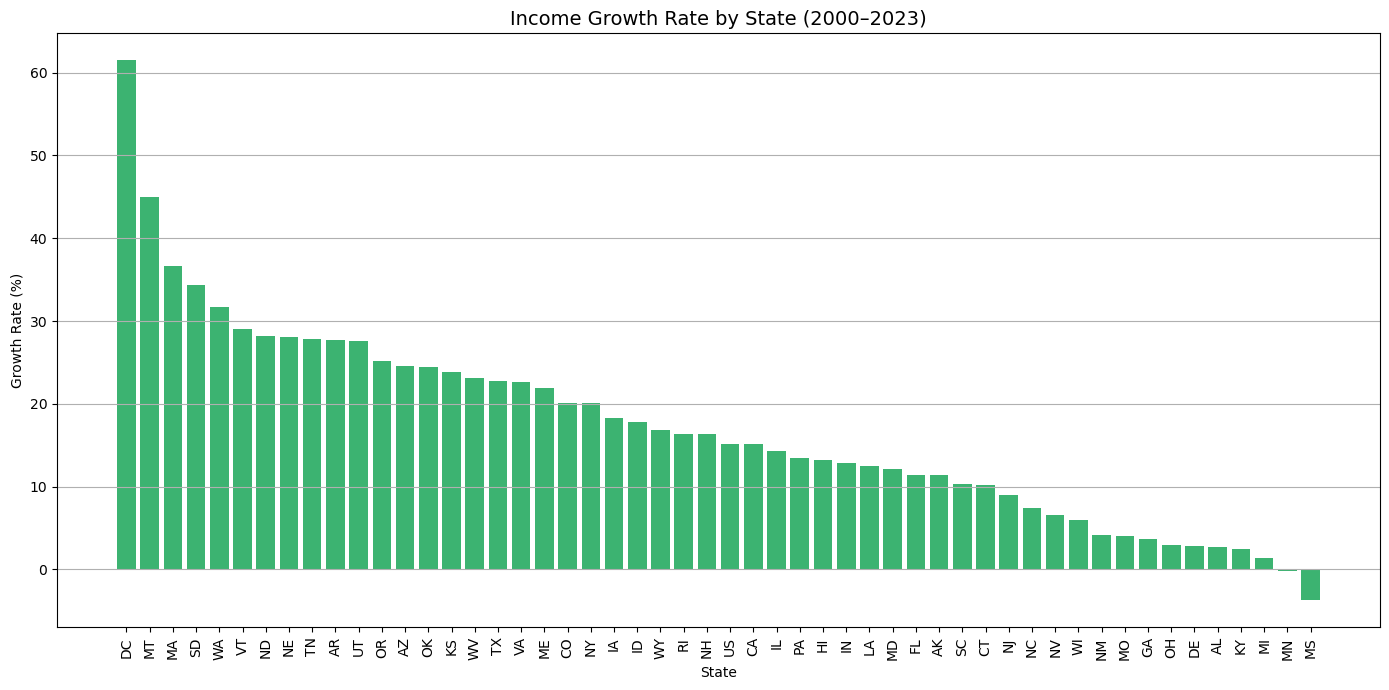

In [33]:
# Step 1: Make sure 2000 and 2023 are columns and are numeric
start_year = 2000
end_year = 2023

# Step 2: Calculate percent change from 2000 to 2023
income_growth = ((income[end_year] - income[start_year]) / income[start_year]) * 100

# Step 3: Create a new DataFrame for visualization
income_growth_df = pd.DataFrame({
    'State': income['State'],
    'StateCode': income['StateCode'],
    'IncomeGrowthRate (%)': income_growth
})

# Step 4: Sort by growth rate
income_growth_df = income_growth_df.sort_values(by='IncomeGrowthRate (%)', ascending=False).reset_index(drop=True)

# Step 5: Plot
plt.figure(figsize=(14, 7))
plt.bar(income_growth_df['StateCode'], income_growth_df['IncomeGrowthRate (%)'], color='mediumseagreen')
plt.title('Income Growth Rate by State (2000–2023)', fontsize=14)
plt.xlabel('State')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [36]:
homevalue_years = list(range(2000, 2024))  # exclude 2024/2025 if needed
us_homevalues_series = state_yearly_df[homevalue_years].median(axis=0)

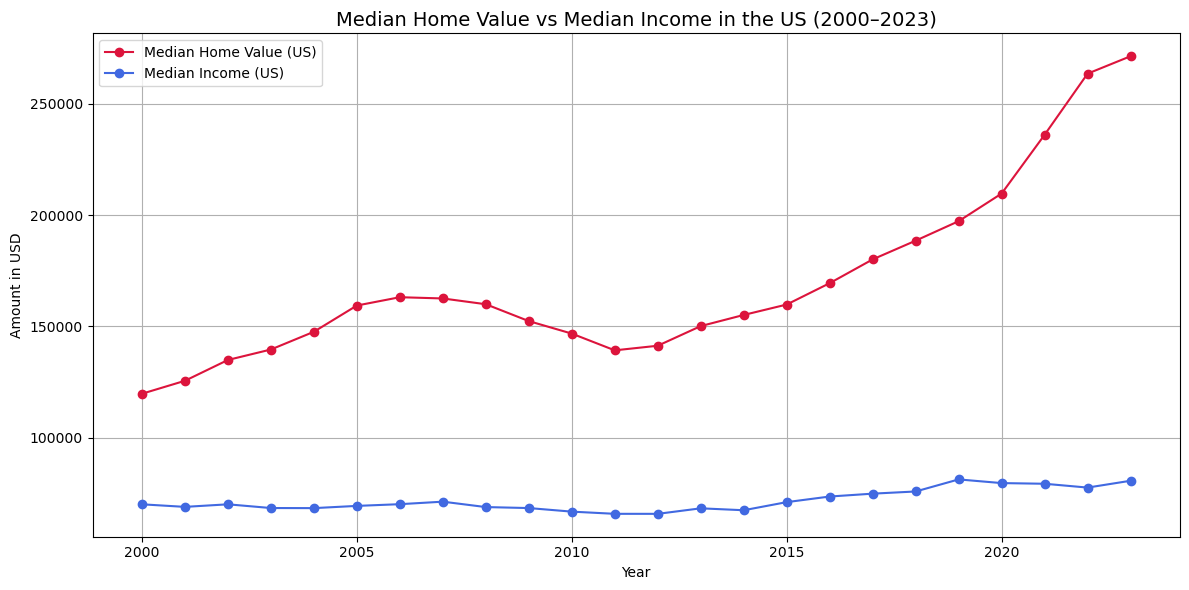

In [22]:
# Step 1: Extract US income row and format it
us_income_series = income[income['State'] == 'The United States'].iloc[:, 1:-1].squeeze()  # skip 'State' and 'StateCode'
us_income_series.index = us_income_series.index.astype(int)
us_income_series.name = "US Income"

# Step 2: Align years with home values series (2000–2023)
common_years = us_homevalues_series.index.intersection(us_income_series.index)
us_homevalues_series = us_homevalues_series[common_years]
us_income_series = us_income_series[common_years]

# Step 3: Plot both on the same chart
plt.figure(figsize=(12, 6))
plt.plot(us_homevalues_series.index, us_homevalues_series.values, label='Median Home Value (US)', color='crimson', marker='o')
plt.plot(us_income_series.index, us_income_series.values, label='Median Income (US)', color='royalblue', marker='o')

plt.title('Median Home Value vs Median Income in the US (2000–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Amount in USD')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# Step 1: Calculate features for each state

# Home value current and growth
home_current = state_yearly_df[2023]
home_growth = ((state_yearly_df[2023] - state_yearly_df[2000]) / state_yearly_df[2000]) * 100

# Income current and growth
income_current = income.set_index('StateCode').loc[state_yearly_df.index][2023]
income_growth = ((income.set_index('StateCode').loc[state_yearly_df.index][2023] -
                  income.set_index('StateCode').loc[state_yearly_df.index][2000]) /
                 income.set_index('StateCode').loc[state_yearly_df.index][2000]) * 100

# Step 2: Create a DataFrame for clustering
clustering_df = pd.DataFrame({
    'HomeValue_2023': home_current,
    'HomeValue_Growth': home_growth,
    'Income_2023': income_current,
    'Income_Growth': income_growth
})

# Drop any rows with missing values just in case
clustering_df = clustering_df.dropna()

# Step 3: Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

# Step 4: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Optional: map cluster labels to affordability level
# (You can sort by income/home ratios to fine-tune this)
cluster_map = {
    0: 'Moderate Affordability',
    1: 'High Affordability',
    2: 'Low Affordability'
}
# You can customize this mapping based on centroid inspection if needed
clustering_df['Affordability'] = clustering_df['Cluster'].map(cluster_map)

# Final result
print(clustering_df.sort_values('Cluster'))

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


           HomeValue_2023  HomeValue_Growth  Income_2023  Income_Growth  \
StateName                                                                 
IL          148540.889778         43.330029      87820.0      14.319188   
PA          204188.323487         97.713694      79820.0      13.493530   
GA          204704.075929        119.074502      72420.0       3.634803   
MI          211754.211222        102.568325      76960.0       1.396574   
MN          271942.459606         86.101897      90340.0      -0.143694   
MO          200694.932831         82.823054      78290.0       4.095200   
OH          173489.841567         95.596550      73770.0       2.958828   
NC          270440.799914        124.382946      68610.0       7.370892   
KY          177174.548190        129.857139      61980.0       2.480159   
LA          175312.817989         55.598366      57650.0      12.531720   
AL          207189.150262        117.204541      60660.0       2.691722   
WI          260791.544058

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less 

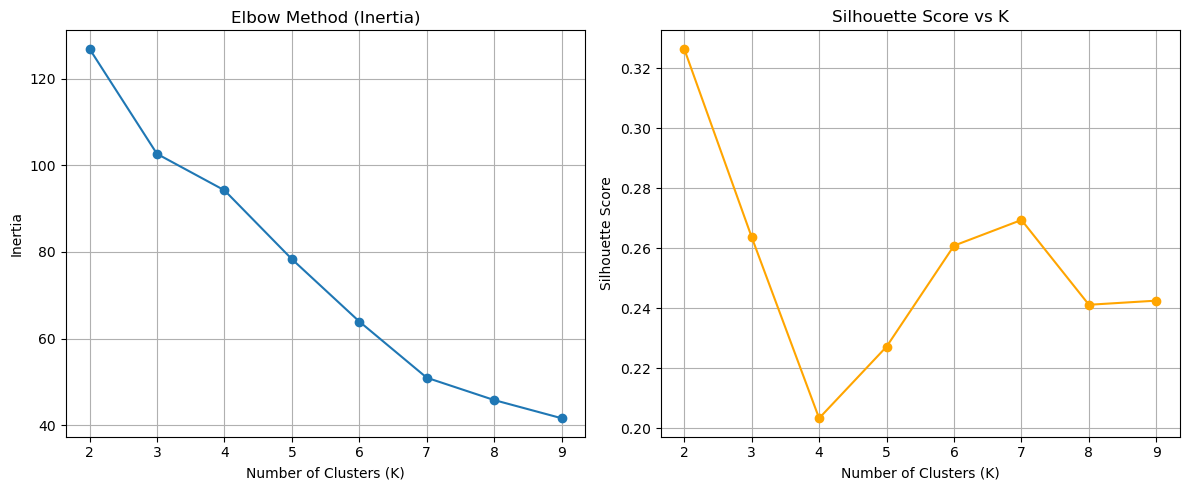

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Range of K values to try
K_range = range(2, 10)

inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)  # scaled_data = standardized feature matrix from earlier
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plotting
plt.figure(figsize=(12, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
cluster_summary = clustering_df.groupby('Cluster')[['HomeValue_2023', 'HomeValue_Growth', 'Income_2023', 'Income_Growth']].mean()
print(cluster_summary)

         HomeValue_2023  HomeValue_Growth   Income_2023  Income_Growth
Cluster                                                               
0         235259.721599         95.412090  73206.111111       5.765314
1         233354.871345        112.056713  77972.307692      26.659559
2         456122.466241        188.376602  89753.157895      19.296517


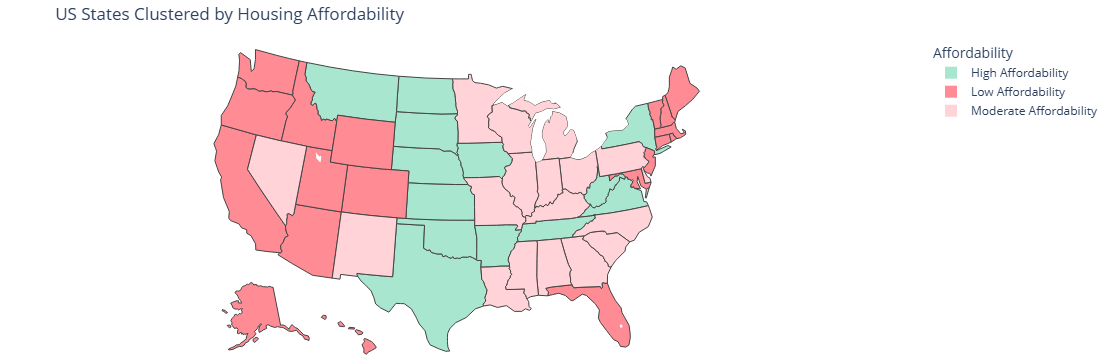

In [51]:
cluster_label_map = {
    0: 'Moderate Affordability',
    1: 'High Affordability',
    2: 'Low Affordability'
}

clustering_df['Affordability'] = clustering_df['Cluster'].map(cluster_label_map)

# Prepare the DataFrame for plotting
map_df = clustering_df.reset_index()[['Affordability']]
map_df['StateCode'] = clustering_df.index

fig = px.choropleth(
    map_df,
    locations='StateCode',
    locationmode='USA-states',
    color='Affordability',
    color_discrete_map={
        'High Affordability': '#A8E6CF',
        'Moderate Affordability': '#FFD3D7',
        'Low Affordability': '#FF8B94'
    },
    hover_name='StateCode',
    scope='usa',
    title='US States Clustered by Housing Affordability'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()